# Similarity Score
Code for creating similarity score

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

import import_ipynb
import riemann
import jblogdet

Open and View File

In [8]:
def open_file(filename, cell):
    df = pd.read_csv(filename)
    #print(list(df))
    pat_col = 'ID'
    state = 'DiseaseState'
    
    print('Information on Dataset %s' % cell)
    print('Shape:', df.shape)
    print('Unique States:', df[state].unique())
    
    pat_id = df[pat_col].unique()
    print('Num of Patients', len(pat_id))
    
    df = df.drop(['Unnamed: 0'], axis=1)
    return df

Types of Cells and Patients

I'm going to rename the 19_227 patient so that the names are all integers

In [9]:
def fix_patientids(df):
    pat_col = 'ID'
    pat_id = df[pat_col].unique()
    
    id_list = []
    for i in range(df.shape[0]):
        patid = df.iloc[i][pat_col]
        if '_' in pat_id:
            patid = patid.strip('_')
        id_list.append(int(patid))
    df[pat_col] = id_list
    return df

In [10]:
def partition_matrices(df):
    pat_col = 'ID'
    pat_id = df[pat_col].unique()
    
    state = 'DiseaseState'
    
    # Partition matrices
    pat_dict = {}
    for id in pat_id:
        pat_dict[id] = []
        subset = df[df[pat_col] == id]
        subset = subset.drop([pat_col, state, 'ID.1', 'DiseaseState.1'], axis = 1) # remove non-numeric columns
        cov_set = np.cov(subset.T) # covariance
        
        pat_dict[id].append(cov_set)
    return pat_dict

# Set Up

In [11]:
prefix = 'data/gene_filtered_matrices_batch_112519/bioinf590_project_'
setlist = ['b_cell','cd4_T_cell','cd8_T_cell','dendritic_cell','epithelial','fibroblast','myeloid','mast_cell','nk_cell']

set_dict = {}
full_dict = {}
for cell in setlist:
    filename = prefix + cell + '_filt_batch_112519.csv'
    cell_df = fix_patientids(open_file(filename, cell))
    full_dict[cell] = cell_df # save the full matrices for PCA
    pat_dict = partition_matrices(cell_df) # save the partitioned matrices for heatmap
    set_dict[cell] = pat_dict

Information on Dataset b_cell
Shape: (479, 781)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Information on Dataset cd4_T_cell
Shape: (2956, 787)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset cd8_T_cell
Shape: (4125, 823)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset dendritic_cell
Shape: (478, 632)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset epithelial
Shape: (5230, 1770)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset fibroblast
Shape: (2950, 1542)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset myeloid
Shape: (9383, 1743)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset mast_cell
Shape: (1753, 960)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11
Information on Dataset nk_cell
Shape: (1008, 803)
Unique States: ['AdjNorm' 'PDAC']
Num of Patients 11


In [12]:
for cell in full_dict.keys():
    df = full_dict[cell]
    sub = df[df['DiseaseState'] == 'AdjNorm']

    print(sub['ID'].unique())

[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]
[ 1196  1258 19732]


# Information About Patients

In [14]:
patient_data = {}
for cell in list(full_dict.keys()):
    subset = full_dict[cell]
    for patient in subset['ID'].unique():
        n_records = subset[subset['ID'] == patient].shape[0]
        if patient not in patient_data:
            patient_data[patient] = []
        patient_data[patient].append(n_records)

table1 = pd.DataFrame.from_dict(patient_data, orient='index', columns=list(full_dict.keys()))
table1

b_cell  cd4_T_cell  cd8_T_cell  dendritic_cell  epithelial  fibroblast  \
1196        2           2          58               2         126          31   
1258        4           8         512              26          50          51   
1294       24         245         174              27         288          49   
1296      121         579         828             160         853         505   
1299       78        1119         805             149         174        1270   
1306        6          69          57              11         460         127   
1314       20         219         244              37         428         188   
1317      155         513         294              31         851          33   
1324        3          33          47               3        1080         143   
19732      54          71         859              24         436         548   
3210       12          98         247               8         484           5   

       myeloid  mast_cell  nk_cell  
1196        66          5        8  
1258       852         77       61  
1294      2900         20      236  
1296       561        329       91  
1299      1684       1073       49  
1306       472          8      113  
1314       613         19      139  
1317       197         15       70  
1324       343          4       71  
19732     1255        199      131  
3210       440          4       39

Note: pat_dict -- each patient has a covariance matrices representing the cell type.
set_dict -- each cell type containing the list of patients and their respective covariance matrices
There used to be a cell type for whether it was blood or tissue I believe?

# Distributions of Data

In [ ]:
subplot(full_dict[''], ncols, index, **kwargs)

# Creating Heatmaps

Create Matrix

In [69]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = plt.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Create the Heatmaps

**Frobenius Norm Maps**

b_cell


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


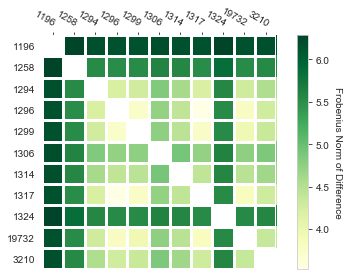

cd4_T_cell


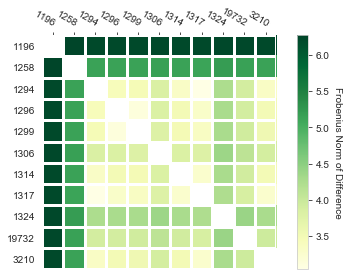

cd8_T_cell


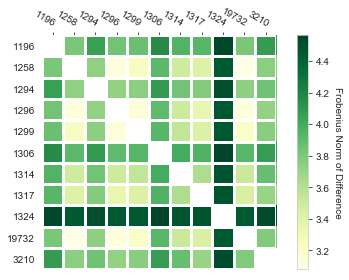

dendritic_cell


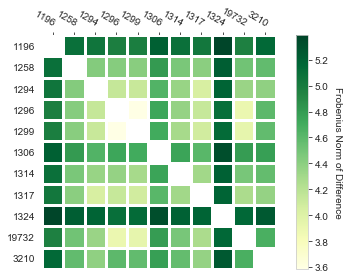

epithelial


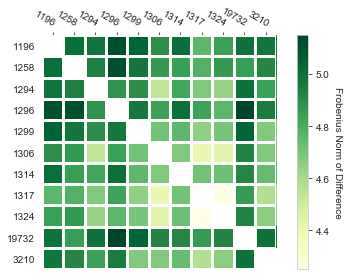

fibroblast


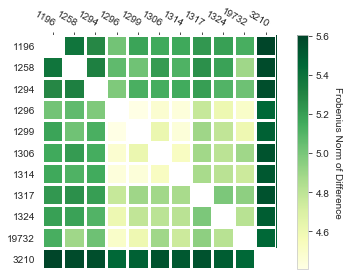

myeloid


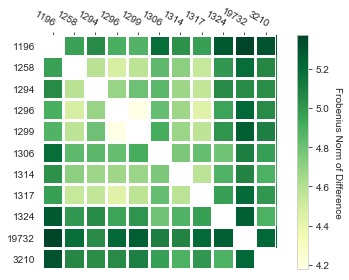

mast_cell


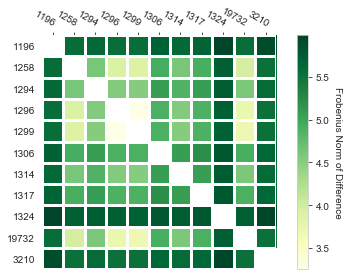

nk_cell


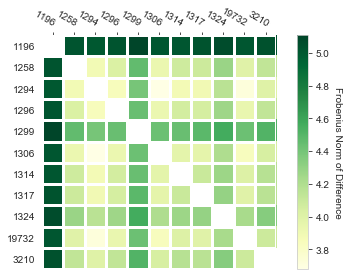

In [228]:
import matplotlib.pyplot as plt

# Create answer matrix
for cell in list(set_dict.keys()):
    print(cell)
    pat_dict = set_dict[cell]
    pat_id = list(pat_dict.keys())
    ans = np.zeros((len(pat_id),len(pat_id)))

    for j in range(len(pat_id)):
        for i in range(len(pat_id)):
            ans[i][j] = np.linalg.norm(np.subtract(pat_dict[pat_id[i]],pat_dict[pat_id[j]])[0], ord = 'fro')
            
    # plot heatmap  
    fig, ax = plt.subplots()

    im, cbar = heatmap(np.log(ans), pat_id, pat_id, ax=ax,
                   cmap="YlGn", cbarlabel="Frobenius Norm of Difference")

    fig.tight_layout()
    #plt.title('Differences of Covariance Matrices')
    plt.show()

**Log-Det**

b_cell


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


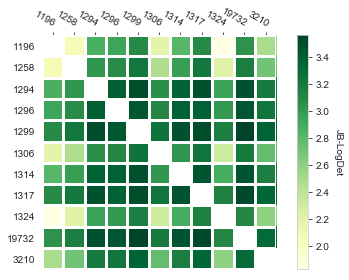

cd4_T_cell


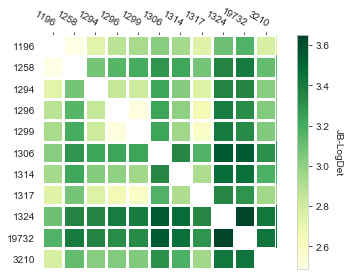

cd8_T_cell


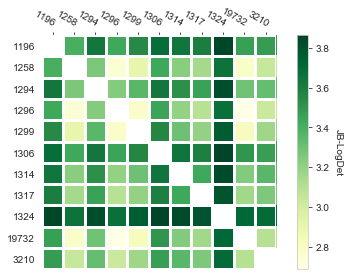

dendritic_cell


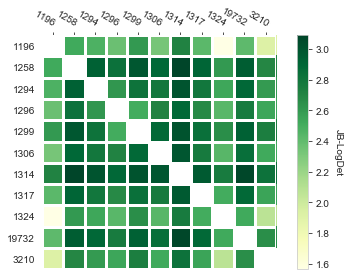

epithelial


jblogdet.ipynb:42: RuntimeWarning: overflow encountered in double_scalars
  "# \n",
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


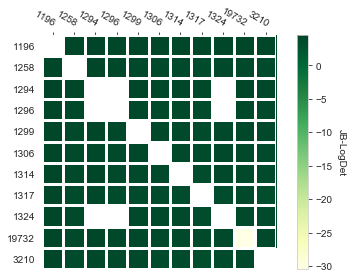

fibroblast


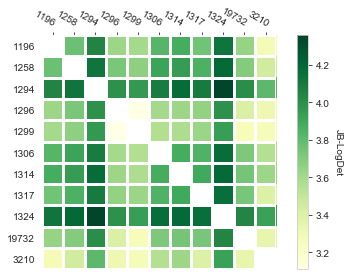

myeloid


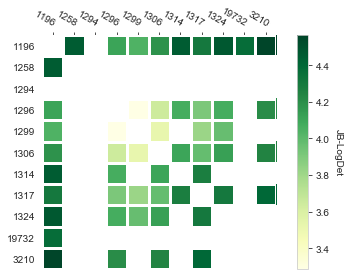

mast_cell


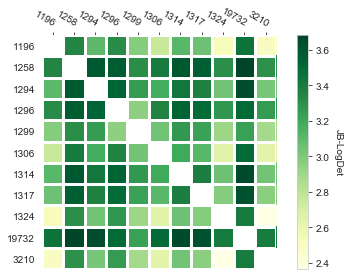

nk_cell


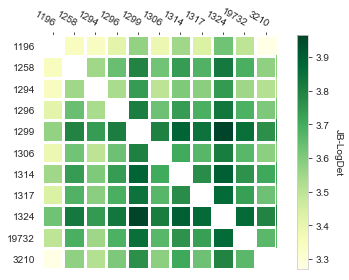

In [229]:
import matplotlib.pyplot as plt
import scipy.stats
lambdax = 1

# Create answer matrix
for cell in list(set_dict.keys()):
    print(cell)
    pat_dict = set_dict[cell]
    pat_id = list(pat_dict.keys())
    ans = np.zeros((len(pat_id),len(pat_id)))

    for j in range(len(pat_id)):
        for i in range(len(pat_id)):
            a = pat_dict[pat_id[i]][0]
            b = pat_dict[pat_id[j]][0]
            
            m,n = pat_dict[pat_id[i]][0].shape
            
            # regularize and reshape 
            a = a + (np.eye(m) * lambdax) # regularize
            b = b + (np.eye(m) * lambdax) # regularize
            #a = np.reshape(a,(1,m,n))
            #b = np.reshape(b,(1,m,n))

            ans[i][j] = jblogdet.jbld(a,b)

            
    # plot heatmap  
    fig, ax = plt.subplots()

    im, cbar = heatmap(np.log(ans), pat_id, pat_id, ax=ax,
                   cmap="YlGn", cbarlabel="JB-LogDet")

    fig.tight_layout()
    #plt.title('Differences of Covariance Matrices')
    plt.show()

Reasons why I didn't use Log-Det:

In [14]:
a = pat_dict[pat_id[2]][0] + np.eye(m)
b = pat_dict[pat_id[3]][0] + np.eye(m)
jblogdet.jbld(a,b)

6.999562633817423

**Vector Version**

b_cell


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


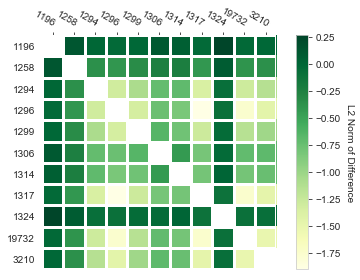

cd4_T_cell


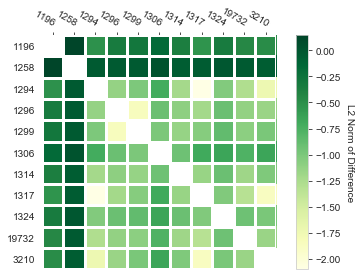

cd8_T_cell


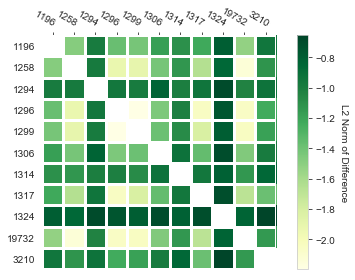

dendritic_cell


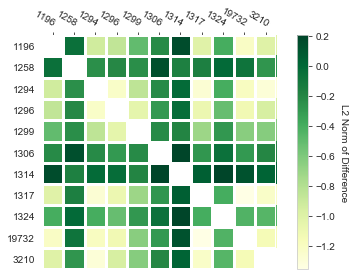

epithelial


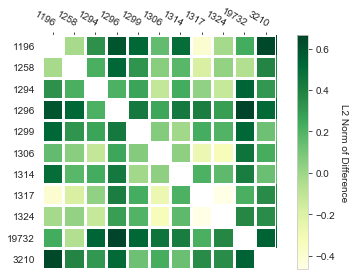

fibroblast


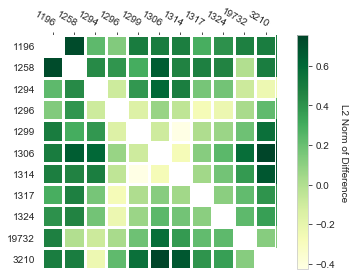

myeloid


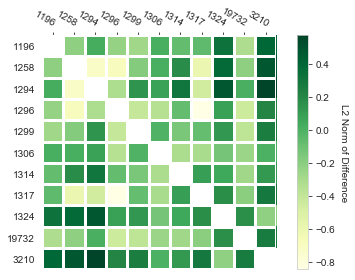

mast_cell


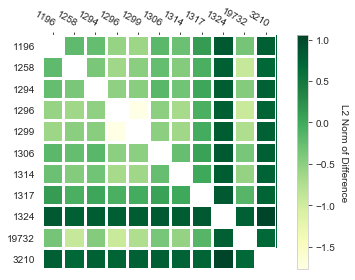

nk_cell


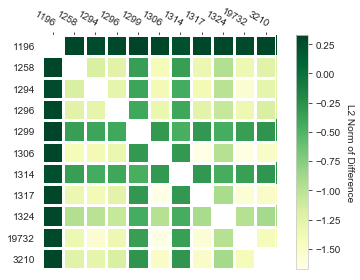

In [230]:
import matplotlib.pyplot as plt

# Create answer matrix
for cell in list(set_dict.keys()):
    print(cell)
    pat_dict = set_dict[cell]
    pat_id = list(pat_dict.keys())
    ans = np.zeros((len(pat_id),len(pat_id)))

    # create vector answer matrix

    for j in range(len(pat_id)):
        for i in range(len(pat_id)): 
            ans[i][j] = np.linalg.norm(np.subtract(np.mean(pat_dict[pat_id[i]],axis=1),np.mean(pat_dict[pat_id[j]],axis=1)), ord = 2)
    
    # make plots
    fig, ax = plt.subplots()

    im, cbar = heatmap(np.log(ans), pat_id, pat_id, ax=ax,
                   cmap="YlGn", cbarlabel="L2 Norm of Difference")

    fig.tight_layout()
    plt.show()    

**SVD Version**

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Create answer matrix
for cell in tqdm(list(set_dict.keys())):
    print(cell)
    pat_dict = set_dict[cell]
    pat_id = list(pat_dict.keys())

    # create answer matrix from SVD
    ans = np.zeros((len(pat_id),len(pat_id)))

    for j in range(len(pat_id)):
        for i in range(len(pat_id)):
        
            if ans[j][i] == 0:
                sing_val = 0

                U,S,V = np.linalg.svd(pat_dict[pat_id[i]])
                U2,S2,V2 = np.linalg.svd(pat_dict[pat_id[j]])

                u = U[0][sing_val].reshape(U[0][sing_val].shape[0], 1)
                v = V[0][sing_val].reshape(V[0][sing_val].shape[0], 1)
                u2 = U2[0][sing_val].reshape(U2[0][sing_val].shape[0], 1)
                v2 = V2[0][sing_val].reshape(V2[0][sing_val].shape[0], 1)
                #u = U[0][sing_val:]
                #v = V[0][sing_val:]
                #u2 = U2[0][sing_val:]
                #v2 = V2[0][sing_val:]

                matrix_1 = np.dot(u,S[0][1]).dot(v.T)
                matrix_2 = np.dot(u2,S2[0][1]).dot(v2.T)
        
                ans[i][j] = np.linalg.norm(np.subtract(matrix_1,matrix_2), ord = 2)
            else:
                ans[i][j] = ans[j][i]
    # plot things
    fig, ax = plt.subplots()

    im, cbar = heatmap(np.log(ans), pat_id, pat_id, ax=ax,
                   cmap="YlGn", cbarlabel="Frobenius Norm of Difference")

    fig.tight_layout()
    plt.show()

What I deleted: Previously, I had information on the distances between particular patients that stood out and everybody else. I removed some cancer patients that shouldn't have had such large distances. And I checked the signular values of the one patient in epithelial who had strangely high first components. This patient, unlike the other patients, had one SV that was extremely highly weighted, while the others were all low contributors. All the other patients had more equal contributions by different SVs

# Removing Patients
Ignore for now

In [428]:
data_epithelial_minus = data_epithelial[data_epithelial.Patient_ID != 181429]
data_epithelial_minus = data_epithelial_minus[data_epithelial_minus.Patient_ID != '181429']
data_epithelial_minus = data_epithelial_minus[data_epithelial_minus.Patient_ID != 61354830]

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# Principal Component Analysis

**NOT log-transformed**

In [220]:
%matplotlib inline

In [16]:
# label cancer vs non-cancer
def calc_labels(df):
    # calculate labels
    label = []
    for row_idx in range(df.shape[0]):
        if df.iloc[row_idx]['DiseaseState'] == 'PDAC':
            label.append(1)
        else:
            label.append(0)

    id_count = []
    dict_o_names = {}
    count = 0
    for row_idx in range(df.shape[0]):
        if df.iloc[row_idx]['ID'] not in dict_o_names:
            dict_o_names[df.iloc[row_idx]['ID']] = count
            id_count.append(count)
            count += 1
        else:
            id_count.append(dict_o_names[df.iloc[row_idx]['ID']])
    return label, id_count

In [22]:
def centroid_2d(x,y):
    # takes x and y vectors
    return np.mean(x), np.mean(y), len(x)

b_cell


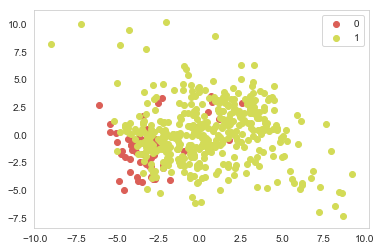

cd4_T_cell


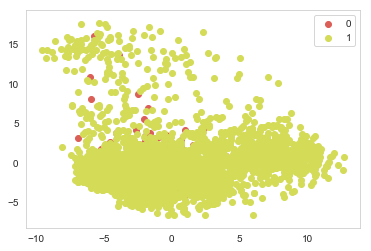

cd8_T_cell


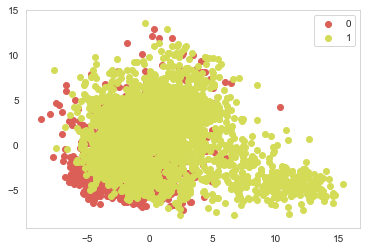

dendritic_cell


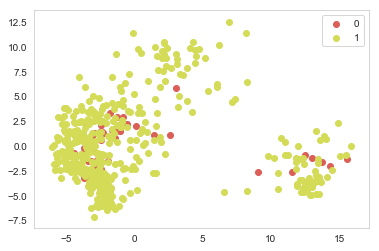

epithelial


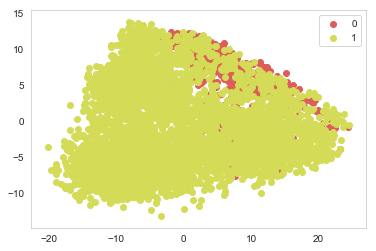

fibroblast


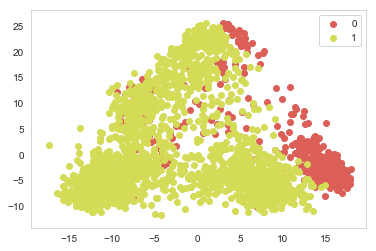

myeloid


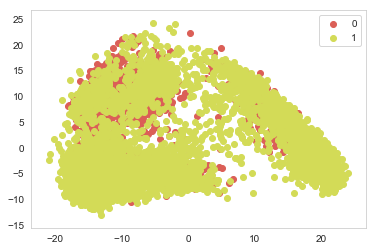

mast_cell


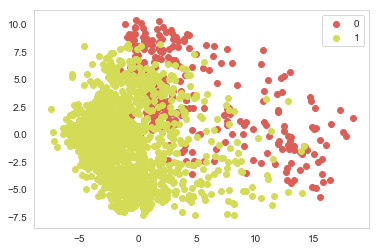

nk_cell


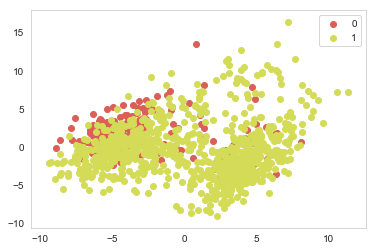

In [223]:
from sklearn.decomposition import PCA

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    principalDf['label'] = label
    principalDf['ID'] = id_count
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values
    
    sns.set_style("whitegrid", {'axes.grid' : False})
    for i in [0,1]:
        subset = principalDf[principalDf['label'] == i]
        plt.scatter(subset['principal component 1'],subset['principal component 2'])
    
    plt.legend([0,1])
    plt.show()

b_cell


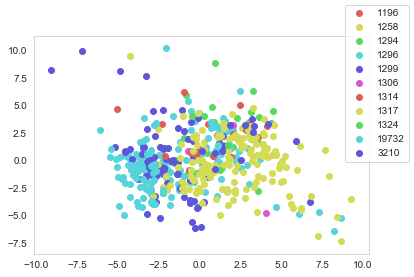

cd4_T_cell


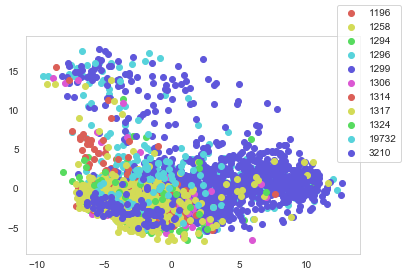

cd8_T_cell


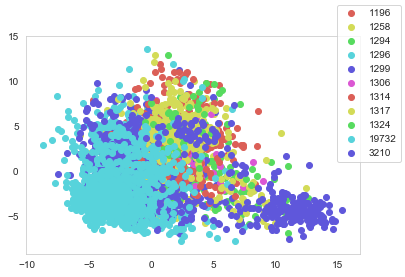

dendritic_cell


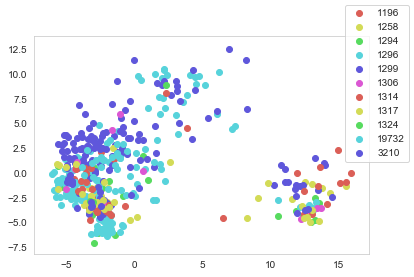

epithelial


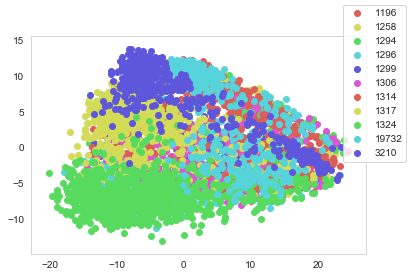

fibroblast


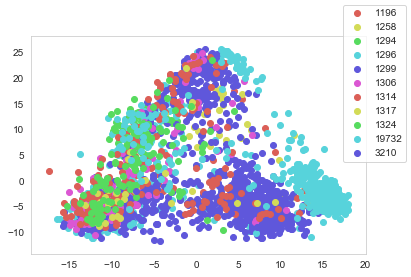

myeloid


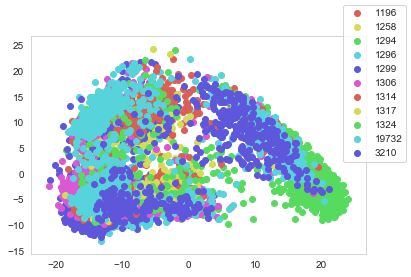

mast_cell


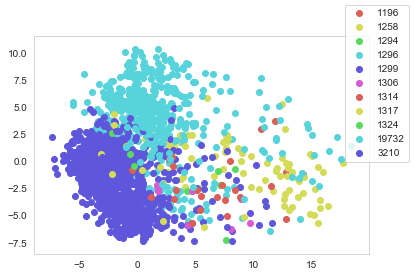

nk_cell


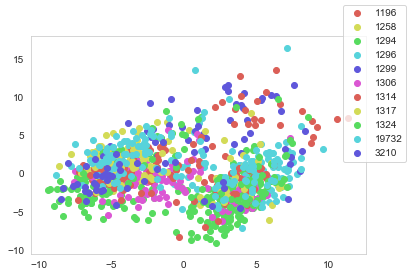

In [224]:
from sklearn.decomposition import PCA

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    sns.set_style("whitegrid", {'axes.grid' : False})
    
    fig = plt.figure()
    for pid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == pid]
        
        plt.scatter(subset['principal component 1'] ,subset['principal component 2'])
    
    fig.legend(principalDf['ID'].unique())
    plt.show()

**With centroids**

b_cell


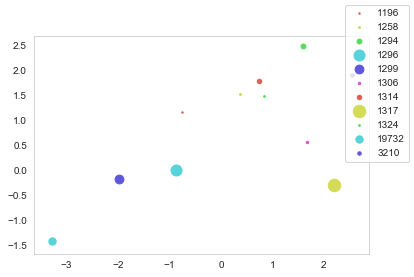

cd4_T_cell


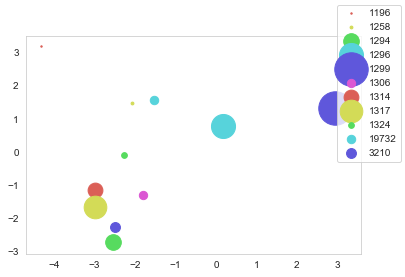

cd8_T_cell


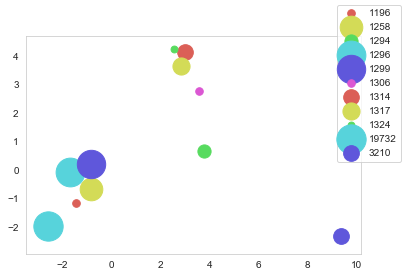

dendritic_cell


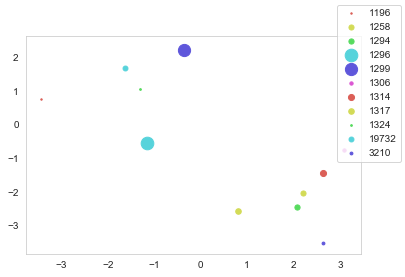

epithelial


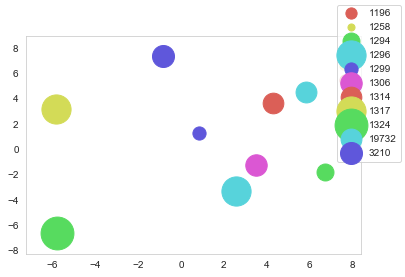

fibroblast


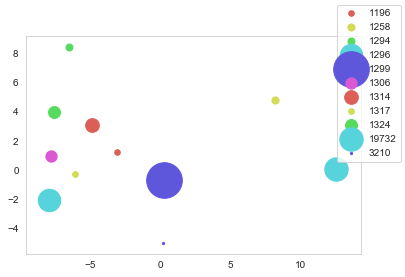

myeloid


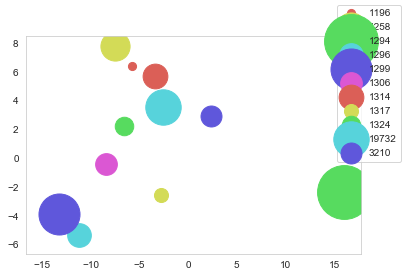

mast_cell


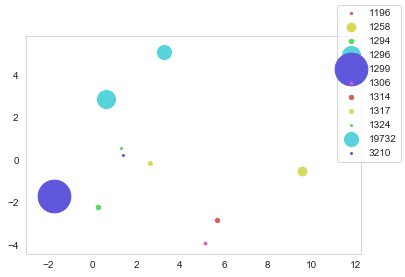

nk_cell


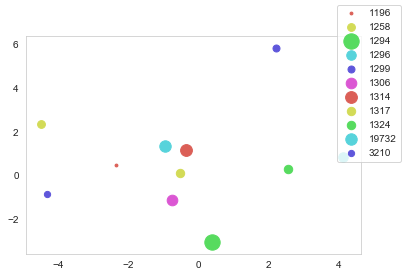

In [225]:
from sklearn.decomposition import PCA

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    sns.set_style("whitegrid", {'axes.grid' : False})
    
    fig = plt.figure()
    for pid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == pid]
        
        a = subset['principal component 1']
        b = subset['principal component 2']
        x,y,s = centroid_2d(a,b)
        plt.scatter(x,y,s=s)
    
    fig.legend(principalDf['ID'].unique())
    plt.show()

**Boxplots**

# 3D

b_cell


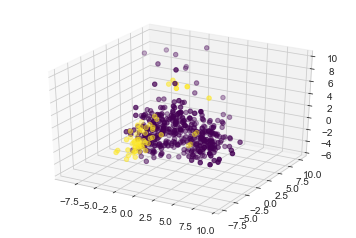

cd4_T_cell


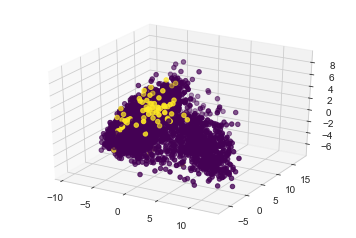

cd8_T_cell


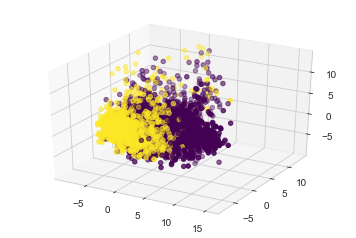

dendritic_cell


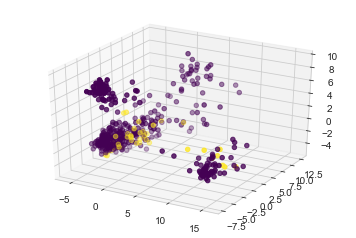

epithelial


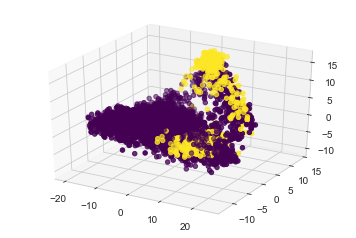

fibroblast


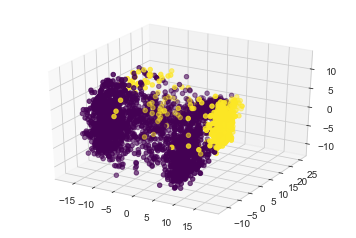

myeloid


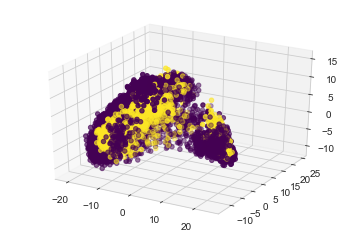

mast_cell


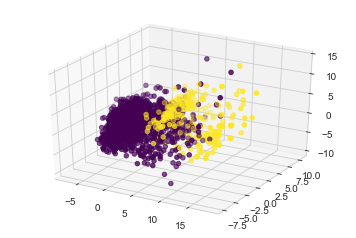

nk_cell


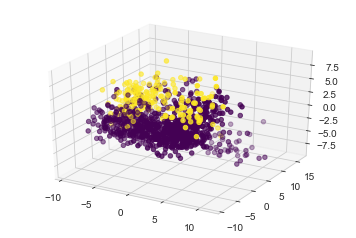

In [226]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values
    
    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'],principalDf['principal component 3'], c=principalDf['label'], cmap='viridis_r')

    plt.show()

b_cell


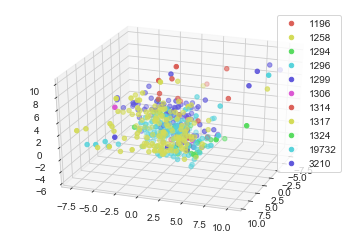

cd4_T_cell


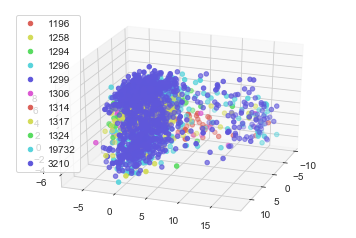

cd8_T_cell


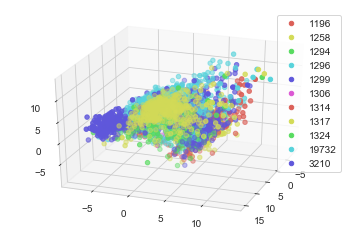

dendritic_cell


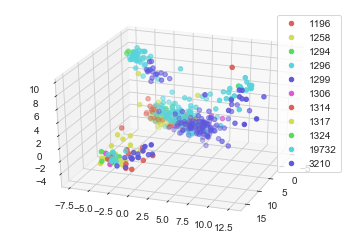

epithelial


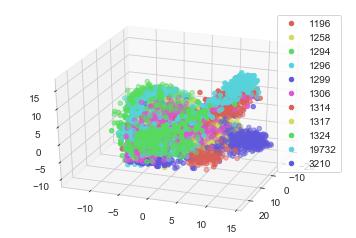

fibroblast


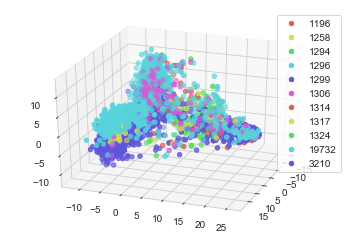

myeloid


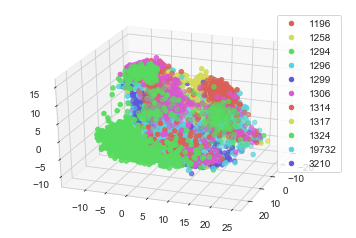

mast_cell


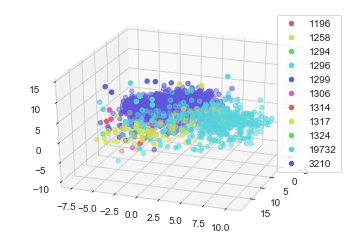

nk_cell


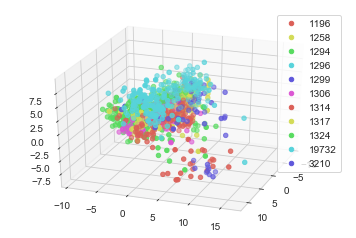

In [227]:
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID'].values
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_palette("hls")
    ax = fig.add_subplot(111, projection='3d')
    for patid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == patid]
        ax.scatter(subset['principal component 1'],subset['principal component 2'],subset['principal component 3'])
        
    ax.legend(principalDf['ID'].unique())
    
    ax.view_init(30, 20)

    plt.show()

**log transformed**

b_cell


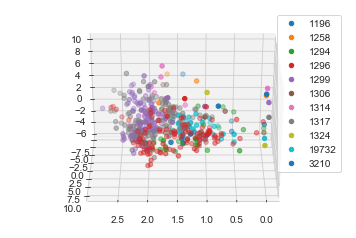

cd4_T_cell


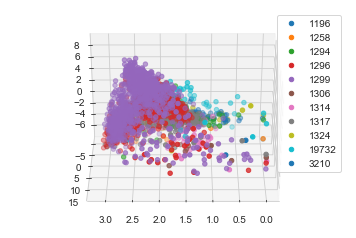

cd8_T_cell


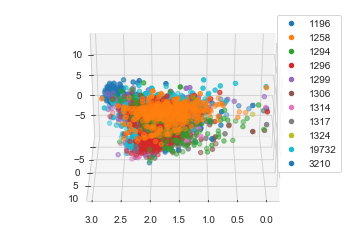

dendritic_cell


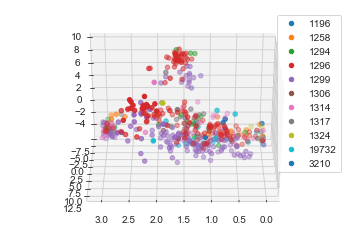

epithelial


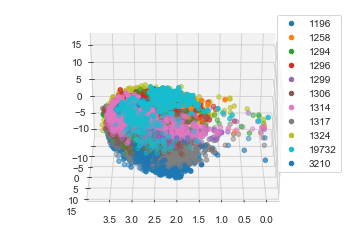

fibroblast


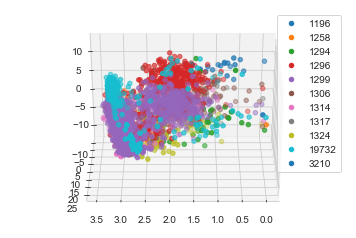

myeloid


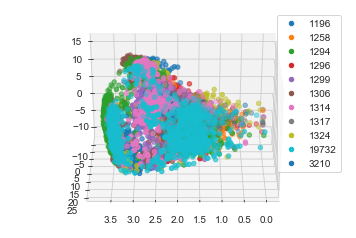

mast_cell


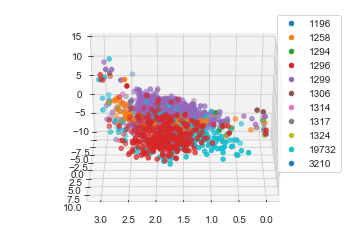

nk_cell


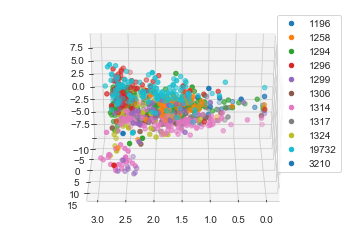

In [18]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')
    
    for patid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == patid]

        a = np.log(subset['principal component 1'] - np.min(subset['principal component 1']) + 1) 
        b = subset['principal component 2']
        z = subset['principal component 3']
        ax.scatter(a,b,z)
    
    ax.legend(principalDf['ID'].unique())
    ax.view_init(30, 90)
    plt.show()

**View Rotation**

In [ ]:
# rotate plots
%matplotlib tk

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['Patient_ID','State','Simple_Relabelling'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['Patient_ID'] = full_dict[cell]['Patient_ID']
    principalDf['State'] = full_dict[cell]['State'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')
    
    for patid in principalDf['Patient_ID'].unique():
        subset = principalDf[principalDf['Patient_ID'] == patid]

        a = subset['principal component 1']
        b = subset['principal component 2']
        z = subset['principal component 3']
        ax.scatter(a,b,z)
    
    ax.legend(principalDf['Patient_ID'].unique())
    
    # rotate the axes and update
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.title(cell)
        plt.draw()
        plt.pause(.0001)

**Video of Rotation**

* To save you need imagemagick:  
    brew install ghostscript  
    brew install imagemagick

  0%|          | 0/9 [00:00<?, ?it/s]

b_cell


 11%|█         | 1/9 [01:04<08:35, 64.40s/it]

cd4_T_cell


 22%|██▏       | 2/9 [03:17<09:56, 85.15s/it]

cd8_T_cell


 33%|███▎      | 3/9 [06:07<11:02, 110.34s/it]

dendritic_cell


 44%|████▍     | 4/9 [07:15<08:09, 97.83s/it] 

epithelial


 56%|█████▌    | 5/9 [10:54<08:56, 134.02s/it]

fibroblast


 67%|██████▋   | 6/9 [13:22<06:54, 138.21s/it]

myeloid


 78%|███████▊  | 7/9 [19:13<06:44, 202.11s/it]

mast_cell


 89%|████████▉ | 8/9 [20:56<02:52, 172.43s/it]

nk_cell


100%|██████████| 9/9 [22:15<00:00, 144.41s/it]


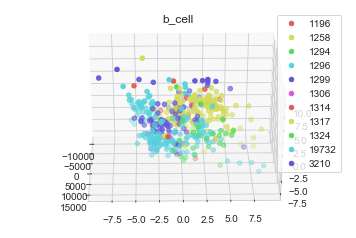

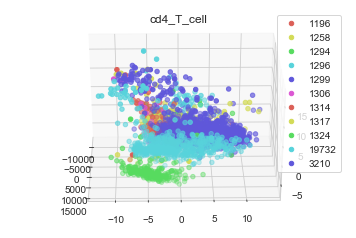

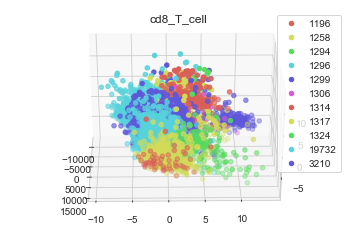

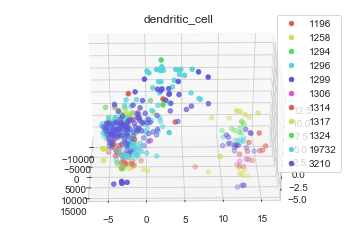

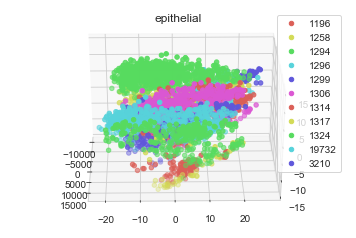

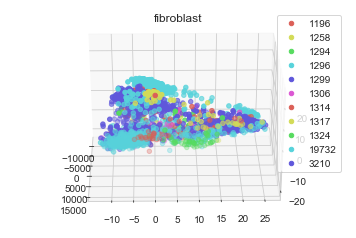

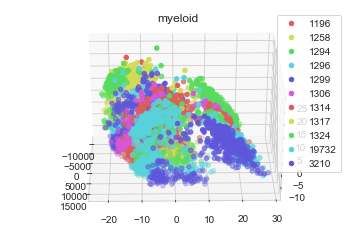

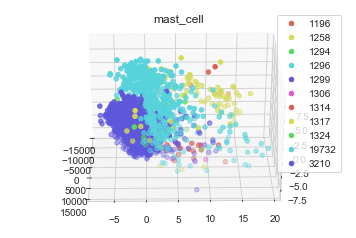

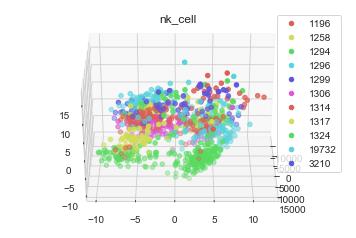

In [112]:
# rotate plots
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from tqdm import tqdm
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

for cell in tqdm(list(full_dict.keys())): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')
    plt.title(cell)
     
    for patid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == patid]

        a = subset['principal component 1']
        b = subset['principal component 2']
        z = subset['principal component 3']
        ax.scatter(a,b,z)
    ax.legend(principalDf['ID'].unique())
    
    animate = lambda i: ax.view_init(30, i)
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=360)
    ani.save('%s.gif' % cell, writer='imagemagick', fps=100)
    #HTML(ani.to_html5_video())

In [ ]:
HTML(ani.to_html5_video())

**Centroid**

In [23]:
def calc_centroid(a,b,z):
    return np.mean(a), np.mean(b), np.mean(z), len(a)

b_cell


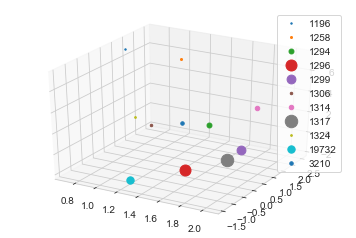

cd4_T_cell


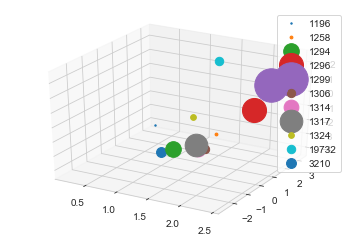

cd8_T_cell


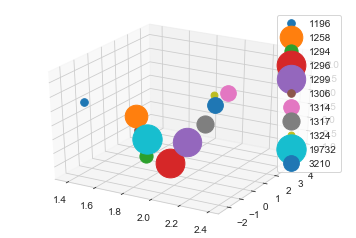

dendritic_cell


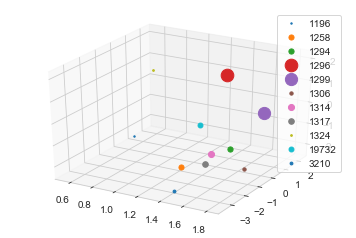

epithelial


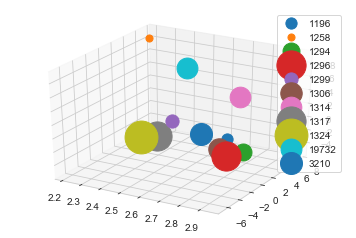

fibroblast


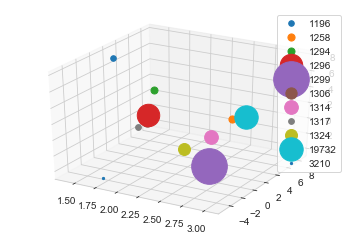

myeloid


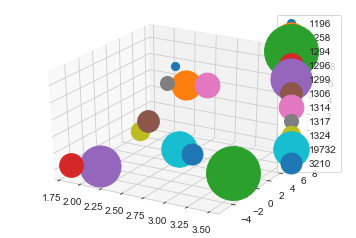

mast_cell


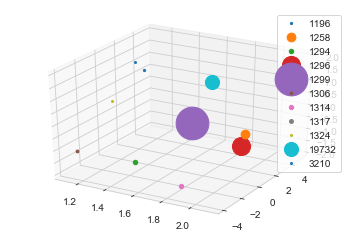

nk_cell


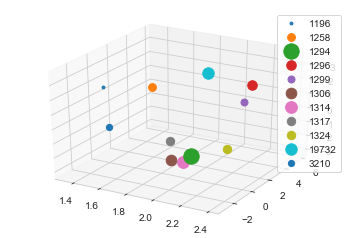

In [24]:
# rotate plots
%matplotlib inline

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

for cell in list(full_dict.keys()): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')
    
    for patid in principalDf['ID'].unique():
        subset = principalDf[principalDf['ID'] == patid]

        a = np.log(subset['principal component 1'] - np.min(subset['principal component 1']) + 1) 
        b = subset['principal component 2']
        z = subset['principal component 3']
        x,y,z,s = calc_centroid(a,b,z)
        ax.scatter(x,y,z, s=s)
    ax.legend(principalDf['ID'].unique())
    
    # rotate the axes and update
    #for angle in range(0, 360):
    #    ax.view_init(30, angle)
    #    plt.title(cell)
    #    plt.draw()
    #    plt.pause(.0001)
    plt.show()

**Not log transformed here:**



  0%|          | 0/9 [00:00<?, ?it/s]

b_cell




 11%|█         | 1/9 [00:52<07:01, 52.68s/it]

cd4_T_cell




 22%|██▏       | 2/9 [02:52<08:28, 72.67s/it]

cd8_T_cell




 33%|███▎      | 3/9 [05:31<09:52, 98.72s/it]

dendritic_cell




 44%|████▍     | 4/9 [06:24<07:04, 84.99s/it]

epithelial




 56%|█████▌    | 5/9 [09:40<07:53, 118.37s/it]

fibroblast




 67%|██████▋   | 6/9 [11:49<06:04, 121.54s/it]

myeloid




 78%|███████▊  | 7/9 [17:13<06:04, 182.20s/it]

mast_cell




 89%|████████▉ | 8/9 [18:43<02:34, 154.70s/it]

nk_cell




100%|██████████| 9/9 [19:50<00:00, 128.26s/it]

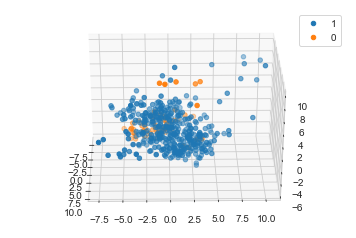

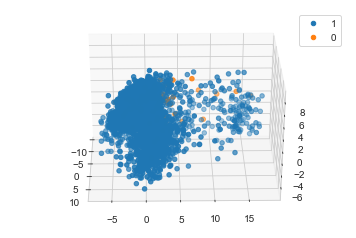

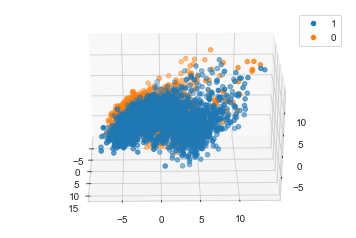

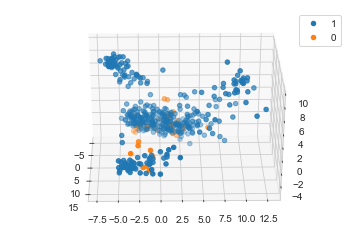

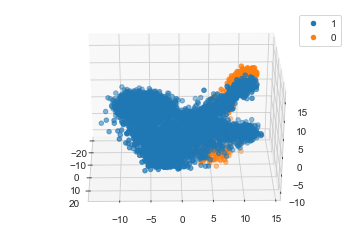

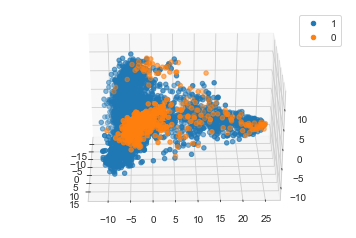

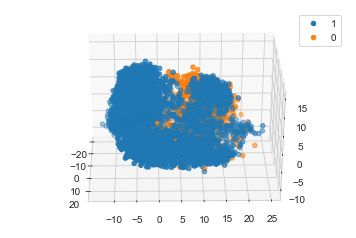

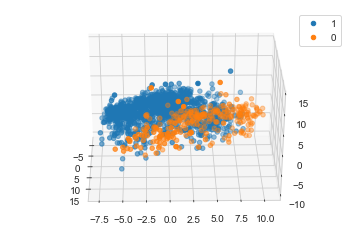

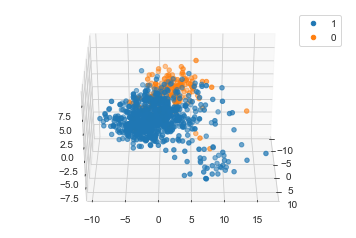

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from tqdm import tqdm

for cell in tqdm(list(full_dict.keys())): 
    print(cell)
    label, id_count = calc_labels(full_dict[cell])
    
    test_set = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(test_set)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    principalDf['label'] = label
    principalDf['ID'] = full_dict[cell]['ID']
    principalDf['DiseaseState'] = full_dict[cell]['DiseaseState'].values

    fig = plt.figure()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = fig.add_subplot(111, projection='3d')

    for i in [1,0]:
        subset = principalDf[principalDf['label'] == i]

        a = subset['principal component 1']
        b = subset['principal component 2']
        z = subset['principal component 3']
        ax.scatter(a,b,z)
    ax.legend([1,0])
    
    animate = lambda i: ax.view_init(30, i)
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=360)
    ani.save('%s_01.gif' % cell, writer='imagemagick', fps=100)
    #HTML(ani.to_html5_video()))

Note: Arvind suggested using other distances (see email). Stephanie will look at Liger and I can try running distances using H-matrix from Liger. Make a table/comparative thing that shows a comparison of all the distances. And try to make some type of graph of patients, not just cells.

# Graph Representation

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
# Weight means how close they are to each other. So higher weight = closer

b_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


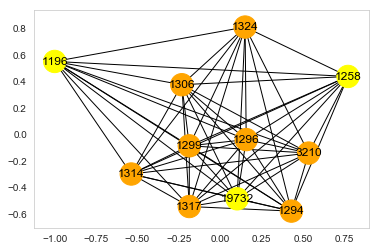

cd4_T_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


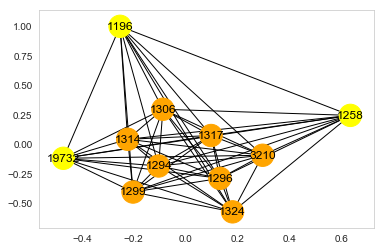

cd8_T_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


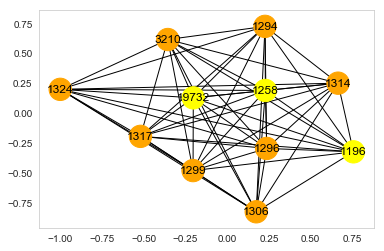

dendritic_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


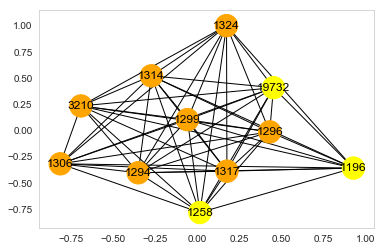

epithelial
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


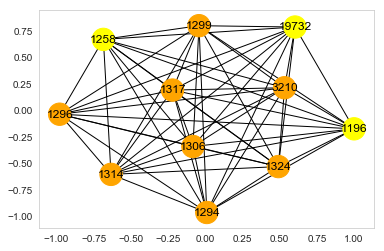

fibroblast
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


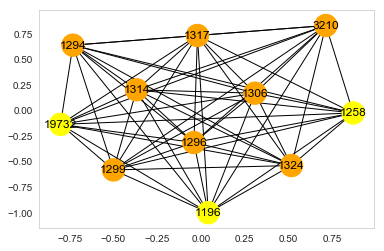

myeloid
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


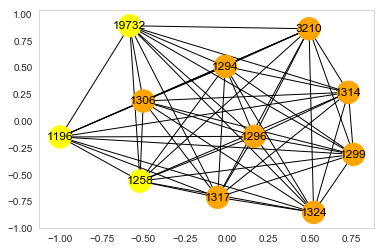

mast_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


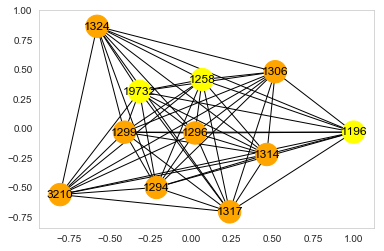

nk_cell
{0: 1196, 1: 1258, 2: 1294, 3: 1296, 4: 1299, 5: 1306, 6: 1314, 7: 1317, 8: 1324, 9: 19732, 10: 3210}


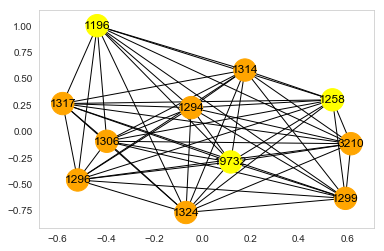

In [33]:
for cell in list(full_dict.keys()): 
    print(cell)
    pat_dict = set_dict[cell]
    pat_id = list(pat_dict.keys())
    
    # create color map
    color_map = []
    for pid in pat_id:
        if pid in [1196,1258,19732]:
            color_map.append('yellow')
        else:
            color_map.append('orange')
    
    # create answer matrix
    ans = np.zeros((len(pat_id),len(pat_id)))
    
    for j in range(len(pat_id)):
        for i in range(len(pat_id)):
            a = pat_dict[pat_id[i]][0]
            b = pat_dict[pat_id[j]][0]
            
            m,n = pat_dict[pat_id[i]][0].shape
            
            #a = a + np.eye(m) * .8
            #b = b + np.eye(m) * .8

            #ans[i][j] = jblogdet.jbld(a,b)
            ans[i][j] = np.linalg.norm(np.subtract(pat_dict[pat_id[i]],pat_dict[pat_id[j]])[0], ord = 'fro')

    # so graph 1/dist
    gans = np.zeros((ans.shape))
    for j in range(ans.shape[1]):
        for i in range(ans.shape[0]):
            if ans[j][i] != 0:
                normalize = (ans[j][i] - np.min(ans)) / (np.max(ans) - np.min(ans))
                gans[j][i] = round(1/normalize,3)

    mapping = {i: pat_id[i] for i in range(len(pat_id))}
    print(mapping)
    G = nx.from_numpy_matrix(gans)
    G=nx.relabel_nodes(G,mapping)
    a = [(u, v, d) for (u, v, d) in G.edges(data=True)]

    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

    pos = nx.spring_layout(G, weight='weight')
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size = 500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, edge_color='black', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, edge_color='b', arrows=True, style='dashed')

    #labels = nx.get_edge_attributes(G,'weight')
    #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

# Random Forest

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

In [214]:
cell = 'cd8_T_cell'
y, id_count = calc_labels(full_dict[cell])
X = full_dict[cell].drop(['ID','DiseaseState','ID.1','DiseaseState.1'],axis = 1)

In [215]:
model = RandomForestClassifier(max_depth=2, random_state=0,n_estimators=100)
model.fit(X, y)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [216]:
print(model.feature_importances_)

[0.         0.02961747 0.00379817 0.03009084 0.01980377 0.00349951
 0.00069445 0.03222867 0.00190159 0.0113759  0.04005685 0.00261925
 0.         0.         0.00794982 0.         0.05365625 0.
 0.00847944 0.         0.         0.02836818 0.         0.01568691
 0.         0.01009663 0.         0.0189938  0.02164618 0.
 0.         0.01769048 0.         0.02933519 0.         0.
 0.         0.00017069 0.00452787 0.         0.00128048 0.
 0.         0.         0.0023331  0.01020386 0.         0.
 0.         0.00340538 0.         0.         0.01048056 0.
 0.         0.         0.         0.         0.01312568 0.
 0.         0.         0.         0.0033748  0.02770644 0.
 0.00961183 0.0001983  0.         0.         0.         0.
 0.         0.00611595 0.00121067 0.         0.         0.00827831
 0.         0.         0.         0.         0.         0.
 0.00977491 0.         0.         0.00037245 0.         0.
 0.         0.         0.00556882 0.         0.         0.
 0.0238949  0.         0

In [217]:
a = [i for i in range(len(model.feature_importances_)) if model.feature_importances_[i] > 0.018]

In [218]:
for name_idx in range(len(a)):
    print(list(full_dict[cell])[name_idx])

CCL5
GZMA
GZMK
CCL4
CD8A
CD2
IL7R
CXCR4
CD3D
AC092580.4
KLRC1
CD7
CD3E
PTPRCAP
CD8B
CD3G
CD69
KLRB1
DUSP2
IL32
HCST
ZFP36L2


In [219]:
full_dict[cell].head()

CCL5      GZMA      GZMK      CCL4      CD8A       CD2      IL7R  \
0  3.410246  1.179192  1.179192  2.945173  2.048368  2.506238  2.819127   
1  3.374663  0.000000  0.000000  3.051789  1.952453  2.404833  3.939306   
2  3.368649  1.099546  0.000000  3.435343  2.198470  2.566243  3.714939   
3  2.825902  0.000000  0.000000  1.603227  2.557779  2.825902  1.939254   
4  1.439980  2.007035  0.000000  0.000000  0.000000  1.666602  3.063260   

      CXCR4      CD3D  AC092580.4  ...      ADAR     COTL1    NBEAL2  \
0  3.829400  0.000000    1.179192  ...  1.179192  1.179192  0.000000   
1  3.721016  2.404833    0.000000  ...  0.000000  1.952453  0.000000   
2  3.808032  1.947111    1.099546  ...  1.099546  0.000000  1.099546   
3  2.700800  1.603227    0.000000  ...  0.000000  1.093439  0.000000   
4  2.630625  1.666602    0.000000  ...  0.729256  0.000000  0.000000   

   IVNS1ABP    NFKBIA     NABP1    ID  DiseaseState  ID.1  DiseaseState.1  
0  0.000000  2.303283  0.000000  1196       AdjNorm  1196         AdjNorm  
1  1.103705  3.441371  0.000000  1196       AdjNorm  1196         AdjNorm  
2  0.000000  1.947111  0.000000  1196       AdjNorm  1196         AdjNorm  
3  0.000000  0.000000  1.093439  1196       AdjNorm  1196         AdjNorm  
4  0.000000  0.729256  0.000000  1196       AdjNorm  1196         AdjNorm  

[5 rows x 822 columns]

In [168]:
regr.n_features_

1766

In [178]:
correct = sum((model.predict(X) - y) == 0)
correct / len(y)

0.9217973231357552